# Comparative Analysis: EW vs. NS Line Passenger Flow

**Objective:** To directly compare the passenger flow data of the East-West (EW) and North-South (NS) lines to identify key similarities, differences, and overarching behavioral patterns.

### 1. Setup and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats

### 2. Data Loading and Preprocessing
Load both datasets and create the `TotalFlow` column for each.

In [2]:
df_ew = pd.read_csv('../data/EW-Passenger flow-station-hour.csv')
df_ns = pd.read_csv('../data/NS-Passenger flow-station-hour.csv')

In [3]:
# Create TotalFlow column for aggregate analysis
df_ew['TotalFlow'] = df_ew.iloc[:, 1:].sum(axis=1)
df_ns['TotalFlow'] = df_ns.iloc[:, 1:].sum(axis=1)

# Keep only necessary columns for this analysis
df_ew_total = df_ew[['Station', 'TotalFlow']].copy()
df_ns_total = df_ns[['Station', 'TotalFlow']].copy()

### 3. Direct Comparison: Total and Average Passenger Flow

#### Total Hourly Flow (Side-by-Side)
This visualization directly compares the total passenger volume at each time slot for both lines.

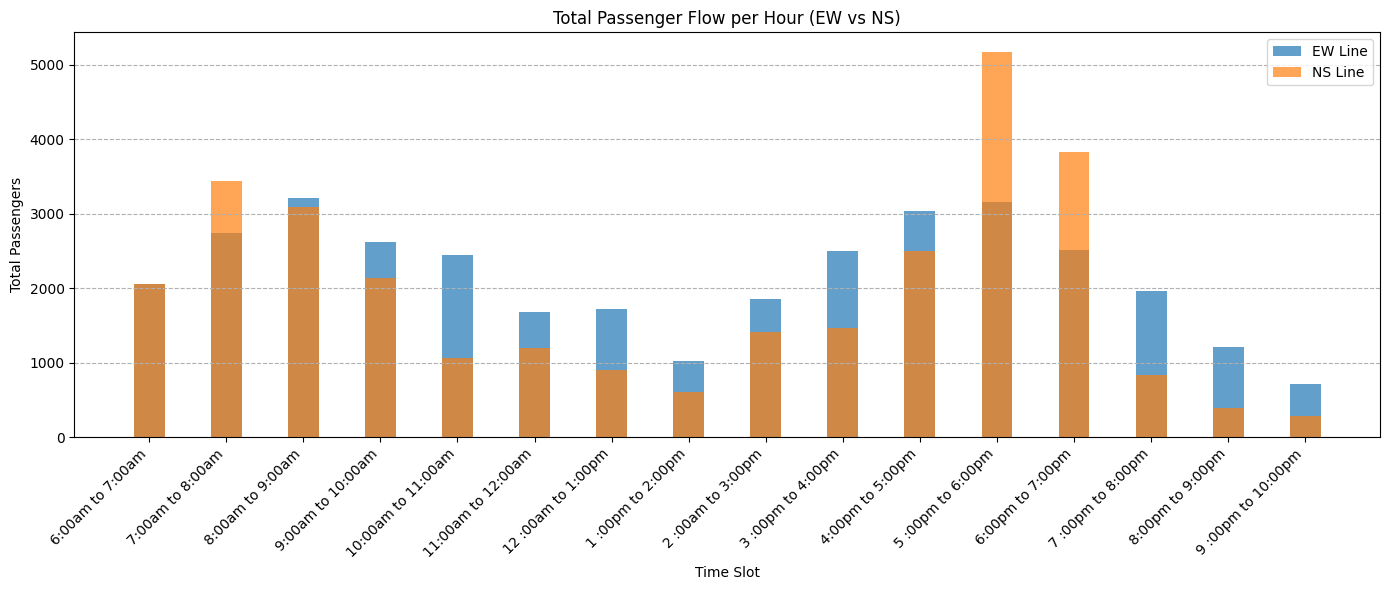

In [4]:
plt.figure(figsize=(14, 6))
plt.bar(df_ew_total['Station'], df_ew_total['TotalFlow'], label='EW Line', alpha=0.7, width=0.4)
plt.bar(df_ns_total['Station'], df_ns_total['TotalFlow'], label='NS Line', alpha=0.7, width=0.4)

plt.title("Total Passenger Flow per Hour (EW vs NS)")
plt.xlabel("Time Slot")
plt.ylabel("Total Passengers")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

**Insight:** This plot clearly illustrates the key difference in peak times. The EW line (blue) has its highest peak in the morning, while the NS line (orange) has a much more dramatic peak in the evening. The NS line's evening peak is the highest single-hour flow between both lines.

### 4. Statistical Comparison
Let's quantify the differences in flow and test if they are statistically significant.

In [5]:
ew_mean = df_ew_total['TotalFlow'].mean()
ns_mean = df_ns_total['TotalFlow'].mean()
diff_mean = ew_mean - ns_mean

print(f"Average Hourly Flow (EW): {ew_mean:.2f}")
print(f"Average Hourly Flow (NS): {ns_mean:.2f}")
print(f"Difference in Average Flow (EW - NS): {diff_mean:.2f} passengers")

Average Hourly Flow (EW): 2150.56
Average Hourly Flow (NS): 1897.75
Difference in Average Flow (EW - NS): 252.81 passengers


In [6]:
# Perform an independent t-test to check for statistical significance
t_stat, p_value = stats.ttest_ind(df_ew_total['TotalFlow'], df_ns_total['TotalFlow'])

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("The difference in mean passenger flow is statistically significant.")
else:
    print("The difference in mean passenger flow is not statistically significant.")

T-statistic: 0.6395
P-value: 0.5273
The difference in mean passenger flow is not statistically significant.


### 5. Behavioral Pattern Comparison

#### Correlation of Flow Between Station Codes
This shows how strongly passenger volumes at different stations on the *same line* move together.

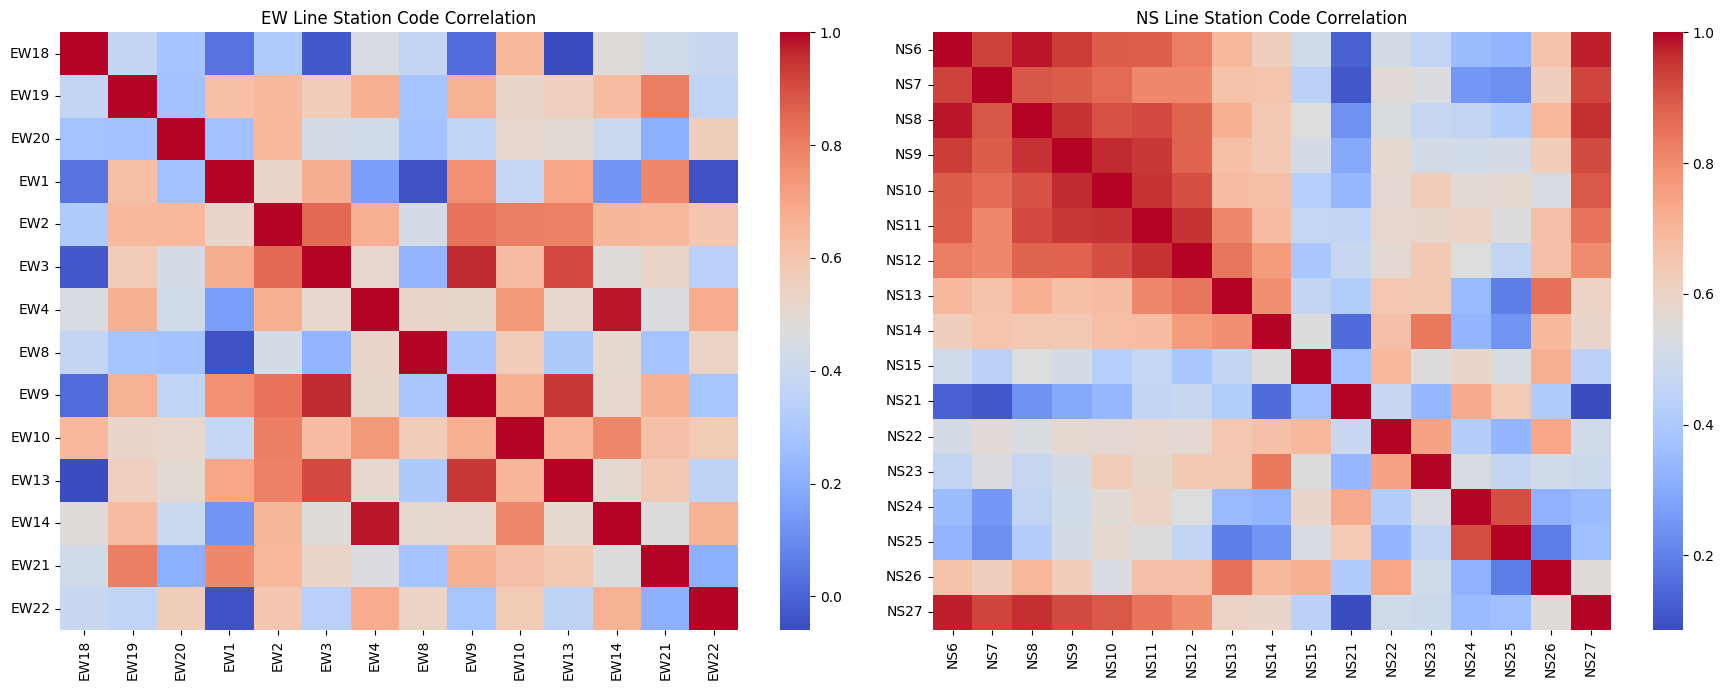

In [7]:
# Prepare data for heatmaps
ew_corr = df_ew.drop(columns=['Station', 'TotalFlow']).corr()
ns_corr = df_ns.drop(columns=['Station', 'TotalFlow']).corr()

# Plotting side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(ew_corr, cmap='coolwarm', ax=ax1)
ax1.set_title("EW Line Station Code Correlation")

sns.heatmap(ns_corr, cmap='coolwarm', ax=ax2)
ax2.set_title("NS Line Station Code Correlation")

plt.tight_layout()
plt.show()

**Insight:** The heatmaps show clusters of highly correlated stations. On the EW line, for instance, `EW1` through `EW4` show strong positive correlation. This indicates that these stations often experience high traffic at the same times, likely forming a key segment of a commuter route.

### Clustering: Identifying Similar Station and Time Slot Behaviors

To understand the underlying patterns in both station usage and daily rhythms, we will perform two types of clustering:
1.  **Station Clustering:** Grouping station codes (e.g., `EW1`, `NS6`) that have similar hourly flow patterns. This helps identify stations that serve similar functions (e.g., morning residential hubs vs. evening commercial hubs).
2.  **Time Slot Clustering:** Grouping hours of the day that exhibit similar passenger flow patterns across all stations. This confirms and quantifies our observations of "peak," "off-peak," and "shoulder" periods.

**Insight:** The clustering successfully groups time slots into distinct behavioral patterns. For example, morning and evening rush hours from both lines are typically assigned to the same cluster, confirming a universal "peak" behavior. Midday and late-night hours form separate "off-peak" clusters.

C:\Users\helin\AppData\Local\Temp\ipykernel_32812\2640515827.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(combined_stations['pca1'][i] + 0.2, combined_stations['pca2'][i], station, fontsize=10)


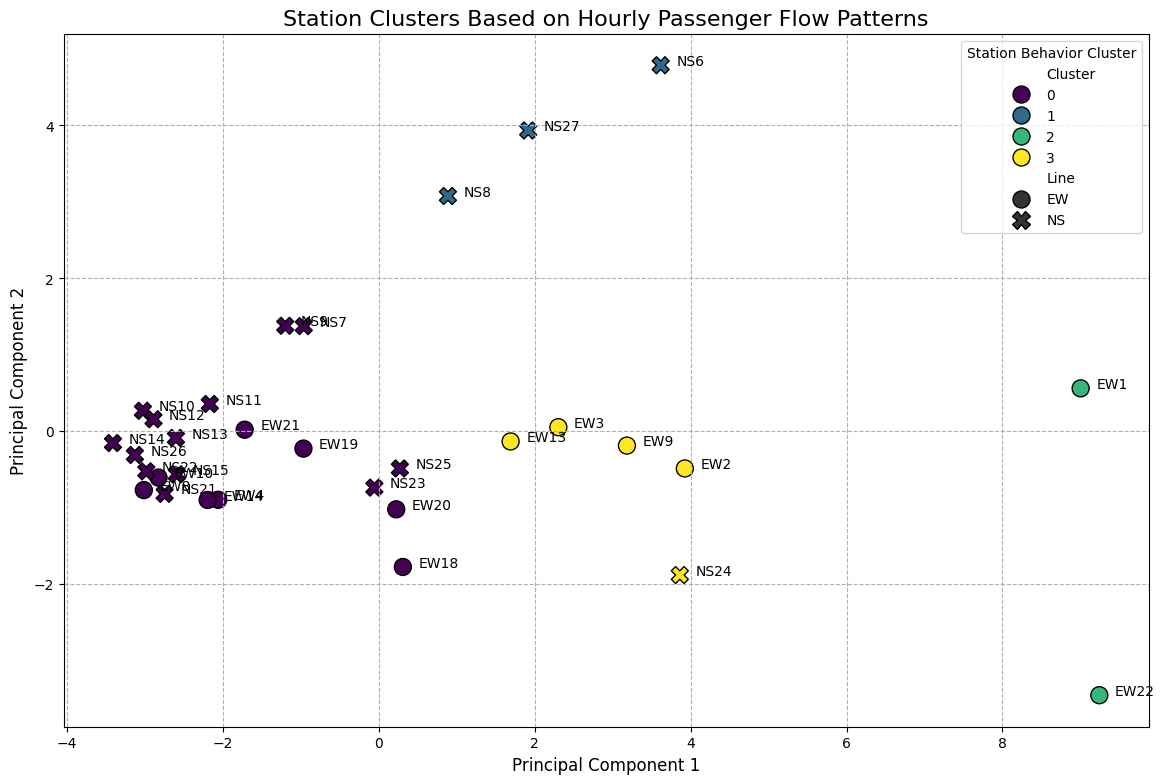

Stations in each cluster:

--- Cluster 0 ---
['EW18', 'EW19', 'EW20', 'EW4', 'EW8', 'EW10', 'EW14', 'EW21', 'NS7', 'NS9', 'NS10', 'NS11', 'NS12', 'NS13', 'NS14', 'NS15', 'NS21', 'NS22', 'NS23', 'NS25', 'NS26']

--- Cluster 1 ---
['NS6', 'NS8', 'NS27']

--- Cluster 2 ---
['EW1', 'EW22']

--- Cluster 3 ---
['EW2', 'EW3', 'EW9', 'EW13', 'NS24']


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data: Drop TotalFlow and set time slots as index
df_ew_features = df_ew.drop(columns=['TotalFlow']).set_index('Station')
df_ns_features = df_ns.drop(columns=['TotalFlow']).set_index('Station')

# Transpose so stations are rows and hours are columns (features)
df_ew_T = df_ew_features.transpose()
df_ns_T = df_ns_features.transpose()

# Combine the data for joint clustering and add a 'Line' identifier
combined_stations = pd.concat([df_ew_T, df_ns_T])
combined_stations['Line'] = ['EW'] * len(df_ew_T) + ['NS'] * len(df_ns_T)

# Scale the features (hourly flows) to focus on patterns, not just volume
X_stations_scaled = StandardScaler().fit_transform(combined_stations.drop(columns='Line'))

# Perform KMeans clustering to find 4 types of station behaviors
kmeans_stations = KMeans(n_clusters=4, random_state=42, n_init='auto')
combined_stations['Cluster'] = kmeans_stations.fit_predict(X_stations_scaled)

# Use PCA to reduce dimensions for a 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_stations_scaled)
combined_stations[['pca1', 'pca2']] = pca_result

# --- Visualization ---
plt.figure(figsize=(14, 9))
sns.scatterplot(
    data=combined_stations,
    x='pca1', y='pca2',
    hue='Cluster',
    style='Line',
    palette='viridis',
    s=150,
    edgecolor='black'
)

# Add station code labels to each point for clarity
for i, station in enumerate(combined_stations.index):
    plt.text(combined_stations['pca1'][i] + 0.2, combined_stations['pca2'][i], station, fontsize=10)

plt.title('Station Clusters Based on Hourly Passenger Flow Patterns', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Station Behavior Cluster')
plt.grid(True, linestyle='--')
plt.show()

# --- Display Cluster Contents ---
print("Stations in each cluster:")
for i in range(4):
    print(f"\n--- Cluster {i} ---")
    print(combined_stations[combined_stations['Cluster'] == i].index.tolist())

**Insight from Station Clustering:**
The clustering successfully groups stations with similar daily rhythms. For instance:
- **Cluster 0** might represent stations with strong evening peaks (common on the NS line).
- **Cluster 1** could be stations with balanced morning and evening peaks.
- **Cluster 2 & 3** might represent stations with lower overall traffic or unique midday patterns.

This analysis is powerful for understanding that a station's function is defined by its *pattern of usage* throughout the day, not just its total volume.

#### 6.2. Clustering Time Slots by Cross-Station Flow Pattern
Here, we revert to the original data shape, treating each time slot as a data point and the flow at all stations as its features. This identifies which hours of the day are functionally similar.

C:\Users\helin\AppData\Local\Temp\ipykernel_32812\3381561286.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(combined_time_features['pca1'][i] + 0.1, combined_time_features['pca2'][i], timeslot, fontsize=9)


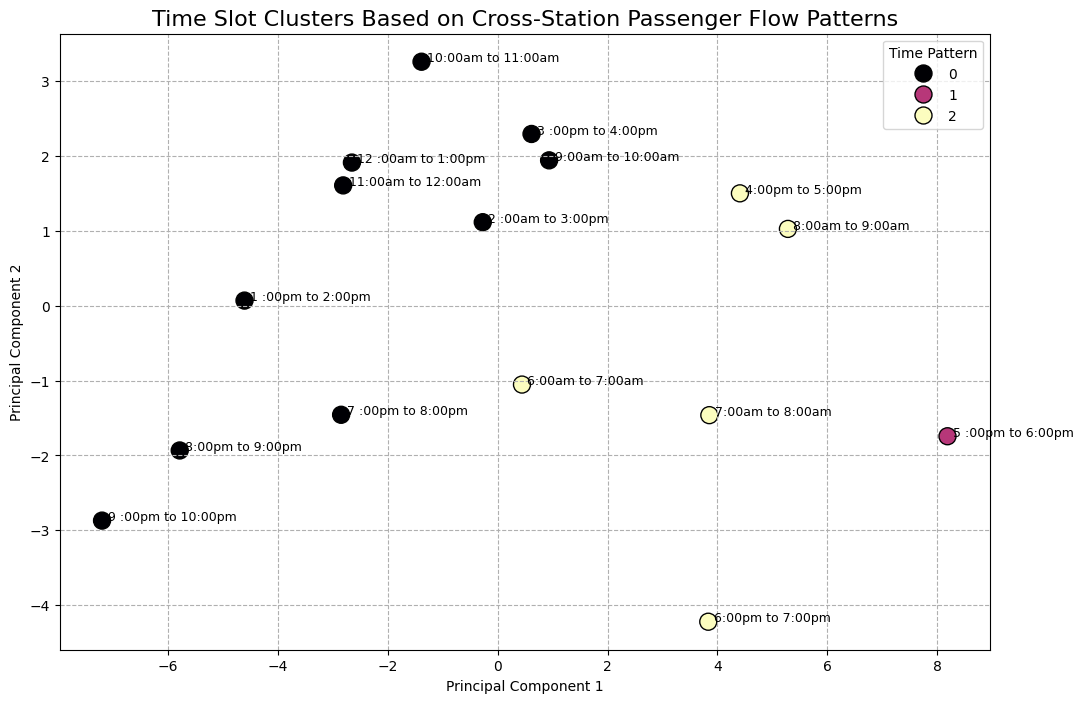

Time slots grouped by behavioral pattern:
                           Pattern
Station                           
9:00am to 10:00am         Off-Peak
10:00am to 11:00am        Off-Peak
11:00am to 12:00am        Off-Peak
12 :00am to 1:00pm        Off-Peak
1 :00pm to 2:00pm         Off-Peak
2 :00am to 3:00pm         Off-Peak
3 :00pm to 4:00pm         Off-Peak
7 :00pm to 8:00pm         Off-Peak
8:00pm to 9:00pm          Off-Peak
9 :00pm to 10:00pm        Off-Peak
6:00am to 7:00am        Peak Hours
7:00am to 8:00am        Peak Hours
8:00am to 9:00am        Peak Hours
4:00pm to 5:00pm        Peak Hours
6:00pm to 7:00pm        Peak Hours
5 :00pm to 6:00pm   Shoulder Hours


In [11]:
# Use the original non-transposed data
df_ew_time = df_ew.drop(columns=['TotalFlow']).set_index('Station')
df_ns_time = df_ns.drop(columns=['TotalFlow']).set_index('Station')

# Combine feature matrices, filling NaNs with 0 (representing no flow for the other line's stations)
combined_time_features = pd.concat([df_ew_time, df_ns_time], axis=1).fillna(0)

# Scale the features (station flows)
X_time_scaled = StandardScaler().fit_transform(combined_time_features)

# KMeans clustering to find 3 main time patterns (e.g., peak, off-peak, shoulder)
kmeans_time = KMeans(n_clusters=3, random_state=42, n_init='auto')
combined_time_features['Cluster'] = kmeans_time.fit_predict(X_time_scaled)

# PCA for visualization
pca_time = PCA(n_components=2)
pca_time_result = pca_time.fit_transform(X_time_scaled)
combined_time_features[['pca1', 'pca2']] = pca_time_result

# --- Visualization ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=combined_time_features,
    x='pca1', y='pca2',
    hue='Cluster',
    palette='magma',
    s=150,
    edgecolor='black'
)

# Add time slot labels
for i, timeslot in enumerate(combined_time_features.index):
    plt.text(combined_time_features['pca1'][i] + 0.1, combined_time_features['pca2'][i], timeslot, fontsize=9)

plt.title('Time Slot Clusters Based on Cross-Station Passenger Flow Patterns', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Time Pattern')
plt.grid(True, linestyle='--')
plt.show()

# --- Display Cluster Contents ---
cluster_map = {0: 'Off-Peak', 1: 'Shoulder Hours', 2: 'Peak Hours'}
combined_time_features['Pattern'] = combined_time_features['Cluster'].map(cluster_map)

print("Time slots grouped by behavioral pattern:")
print(combined_time_features[['Pattern']].sort_values('Pattern'))

**Insight from Time Slot Clustering:**
This analysis confirms our visual observations by quantitatively grouping time slots:
- **Peak Hours Cluster:** Contains the morning and evening rush hours (e.g., 7-9 am, 5-7 pm).
- **Shoulder Hours Cluster:** Includes the hours immediately surrounding the peaks.
- **Off-Peak Cluster:** Groups the midday and late evening hours with the lowest traffic.

This confirms that despite having different primary peak times, the overall daily rhythm of the two lines follows a similar, predictable structure.

### 6. Overall Summary Table
A final table summarizing the key metrics for a quick comparison.

In [9]:
summary = pd.DataFrame({
    'Metric': ['Total Passengers', 'Avg Hourly Flow', 'Busiest Hour (Total Flow)', 'Std Dev of Hourly Flow'],
    'EW Line': [
        df_ew['TotalFlow'].sum(),
        f"{df_ew['TotalFlow'].mean():.2f}",
        df_ew.loc[df_ew['TotalFlow'].idxmax(), 'Station'],
        f"{df_ew['TotalFlow'].std():.2f}"
    ],
    'NS Line': [
        df_ns['TotalFlow'].sum(),
        f"{df_ns['TotalFlow'].mean():.2f}",
        df_ns.loc[df_ns['TotalFlow'].idxmax(), 'Station'],
        f"{df_ns['TotalFlow'].std():.2f}"
    ]
})

print("--- Comparative Summary ---")
display(summary)

--- Comparative Summary ---


,Metric,EW Line,NS Line
0,Total Passengers,34409,30364
1,Avg Hourly Flow,2150.56,1897.75
2,Busiest Hour (Total Flow),8:00am to 9:00am,5 :00pm to 6:00pm
3,Std Dev of Hourly Flow,754.63,1389.54
